In [1]:
from chxanalys.chx_packages import *
%matplotlib notebook
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
import pandas as pds
#%reset -f  #for clean up things in the memory

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from chxanalys.chx_libs import colors, markers
#from chxanalys.chx_xpcs_xsvs_jupyter_V1 import plot_entries_from_uids

# Functions to be included in the analysis package:

In [3]:
def pad_length(arr,pad_val=np.nan):
    """
    arr: 2D matrix
    pad_val: values being padded
    adds pad_val to each row, to make the length of each row equal to the lenght of the longest row of the original matrix
    -> used to convert python generic data object to HDF5 native format
    function fixes python bug in padding (np.pad) integer array with np.nan
    by LW 12/30/2017
    """
    max_len=[]
    for i in range(np.shape(arr)[0]):
        #print(np.size(arr[i]))
        max_len.append([np.size(arr[i])])
    #print(max_len)
    max_len=np.max(max_len)
    for l in range(np.shape(arr)[0]):
        arr[l]=np.pad(arr[l]*1.,(0,max_len-np.size(arr[l])),mode='constant',constant_values=pad_val)
    return arr

In [4]:
def get_roi_nr(qdict,q,phi,q_nr=True,phi_nr=False, silent=True):
    """
    function to return roi number from qval_dict, corresponding  Q and phi, lists (sets) of all available Qs and phis
    [roi_nr,Q,phi,Q_list,phi_list]=get_roi_nr(..)
    calling sequence: get_roi_nr(qdict,q,phi,q_nr=True,phi_nr=False, verbose=True)
    qdict: qval_dict from analysis pipeline/hdf5 result file
    q: q of interest, can be either value (q_nr=False) or q-number (q_nr=True)
    phi: phi of interest, can be either value (phi_nr=False) or q-number (phi_nr=True)
    silent=True/False: Don't/Do print lists of available qs and phis, q and phi of interest
    by LW 20/21/2017
    """
    qs=[]
    phis=[]
    for i in qdict.keys():
        qs.append(qdict[i][0])
        phis.append(qdict[i][1])
    from collections import OrderedDict
    qslist=list(OrderedDict.fromkeys(qs))
    phislist=list(OrderedDict.fromkeys(phis))
    if q_nr:
        qinterest=qslist[q]
    else: qinterest=q
    if phi_nr:
        phiinterest=phislist[phi]
    else: phiinterest=phi
    qindices = [i for i,x in enumerate(qs) if x == qinterest]
    phiindices = [i for i,x in enumerate(phis) if x == phiinterest]
    ret_list=[list(set(qindices).intersection(phiindices))[0],qinterest,phiinterest,qslist,phislist]
    if silent == False:
        print('list of available Qs:')
        print(qslist)
        print('list of available phis:')
        print(phislist)
        print('Roi number for Q= '+str(ret_list[1])+' and phi= '+str(ret_list[2])+': '+str(ret_list[0]))
    return ret_list

In [5]:
# function to get indices of local extrema (=indices of speckle echo maximum amplitudes):
def get_echos(dat_arr,min_distance=10):
    """
    getting local maxima and minima from 1D data -> e.g. speckle echos
    strategy: using peak_local_max (from skimage) with min_distance parameter to find well defined local maxima
    using np.argmin to find absolute minima between relative maxima
    returns [max_ind,min_ind] -> lists of indices corresponding to local maxima/minima
    by LW 10/23/2018
    """
    from skimage.feature import peak_local_max
    max_ind=peak_local_max(dat_arr, min_distance)   # !!! careful, skimage function reverses the order (wtf?)
    min_ind=[]
    for i in range(len(max_ind[:-1])):
        min_ind.append(max_ind[i+1][0]+np.argmin(dat_arr[max_ind[i+1][0]:max_ind[i][0]]))
    #unfortunately, skimage function fu$$s up the format: max_ind is an array of a list of lists...fix this:
    mmax_ind=[]
    for l in max_ind:
        mmax_ind.append(l[0])
    #return [mmax_ind,min_ind]
    return [list(reversed(mmax_ind)),list(reversed(min_ind))]

# Define Result Path here

In [6]:
inDir = '/XF11ID/analysis/2017_3/lwiegart/Results/'
outDir = '/XF11ID/analysis/2017_3/lwiegart/Results/'

In [7]:
cd /XF11ID/analysis/2017_3/lwiegart/Results/

/XF11ID/analysis/2017_3/lwiegart/Results


In [8]:
save_data=True   #save processed data to HDF5 file in outDir
phi=[-90,-180]    # phis to pick from phi map (only works for two phis)
Q_nr=3            # index of Q to use in plots, etc. Can be modified in the respective cells

In [9]:
#uids to analyse (note: need correlation functions from XPCS pipeline)
uid = 'ce3b2b' #'1st periodic stretch (250um, 2s wait)'

In [10]:
# load data from XPCS pipeline
uid_full =  get_meta_data( uid )['uid']
total_res = {}
total_res[uid] = extract_xpcs_results_from_h5( filename = 'uid=%s_phi_Res.h5'%uid_full, import_dir = inDir+ uid + '/' )
print( total_res[uid].keys()   )

dict_keys(['g2_fit_paras', 'taus_uids', 'times_roi', 'roi_mask', 'g4', 'g2b_fit_paras', 'avg_img', 'mask', 'taus', 'bad_frame_list', 'mean_int_sets', 'qval_dict_p', 'g12b', 'taus4', 'g2', 'q_saxs', 'g2b', 'qval_dict_v', 'tausb', 'qval_dict', 'g2_uids', 'iq_saxs', 'qt', 'imgsum', 'md', 'pixel_mask', 'iqst'])


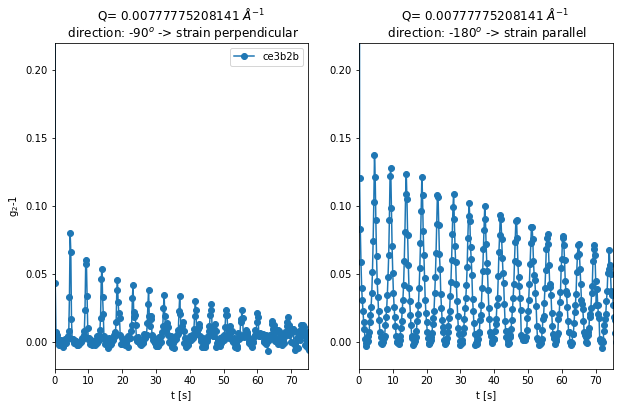

In [11]:
Q_nr=Q_nr    # Q_nr=Q_nr or specify a different Q here
#phi=[90,-180]   #can re-define phi, if necessary
roi_nr=[]
for i in phi:
    #roi_nr.append(get_roi_nr(total_res[list( suid_dict.keys() )[0]]['qval_dict'],Q_nr,i,q_nr=True,phi_nr=False, silent=True)[0])
    roi_nr.append(get_roi_nr(total_res[uid]['qval_dict'],Q_nr,i,q_nr=True,phi_nr=False, silent=True)[0])
    

f, (ax1, ax2,ax3) = plt.subplots(1,3, sharex='col', sharey='row',figsize=(10, 6))
plt.subplot(1,2,1)

plt.plot(total_res[uid]['tausb'],total_res[uid]['g2b'][:,roi_nr[0]]-1,'o-',label=uid)
plt.title('Q= '+str(total_res[uid]['qval_dict'][roi_nr[0]][0])+' $\AA^{-1}$ \n direction: '+str(phi[0])+'$^o$ -> strain perpendicular')
plt.xlabel('t [s]');plt.ylabel('g$_2$-1')
plt.ylim(-.02,.22)
plt.legend(fontsize=10)
plt.xlim(0,75)

plt.subplot(1,2,2)

plt.plot(total_res[uid]['tausb'],total_res[uid]['g2b'][:,roi_nr[1]]-1,'o-',label=uid)
plt.title('Q= '+str(total_res[uid]['qval_dict'][roi_nr[0]][0])+' $\AA^{-1}$ \n direction: '+str(phi[1])+'$^o$ -> strain parallel')
plt.ylim(-.02,.22)
plt.xlim(0,75)
plt.xlabel('t [s]')

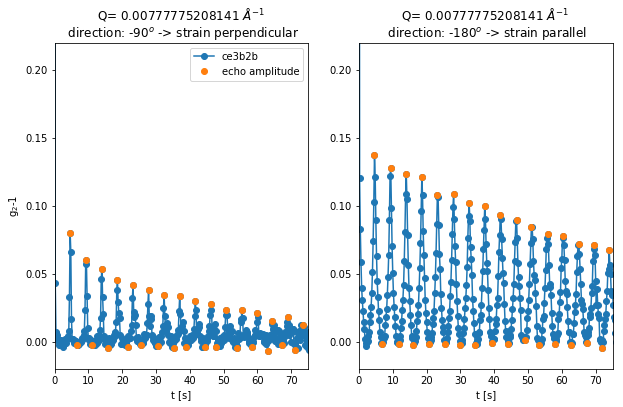

In [12]:
Q_nr=Q_nr    # Q_nr=Q_nr or specify a different Q here
#phi=[90,-180]   #can re-define phi, if necessary
roi_nr=[]
for i in phi:
    #roi_nr.append(get_roi_nr(total_res[list( suid_dict.keys() )[0]]['qval_dict'],Q_nr,i,q_nr=True,phi_nr=False, silent=True)[0])
    roi_nr.append(get_roi_nr(total_res[uid]['qval_dict'],Q_nr,i,q_nr=True,phi_nr=False, silent=True)[0])

f, (ax1, ax2,ax3) = plt.subplots(1,3, sharex='col', sharey='row',figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(total_res[uid]['tausb'],total_res[uid]['g2b'][:,roi_nr[0]]-1,'o-',label=uid)
[max_ind,min_ind]=get_echos(total_res[uid]['g2b'][:,roi_nr[0]]-1)
plt.plot(total_res[uid]['tausb'][sorted(max_ind+min_ind)],total_res[uid]['g2b'][sorted(max_ind+min_ind),roi_nr[0]]-1,'o',label='echo amplitude')   
plt.title('Q= '+str(total_res[uid]['qval_dict'][roi_nr[0]][0])+' $\AA^{-1}$ \n direction: '+str(phi[0])+'$^o$ -> strain perpendicular')
plt.xlabel('t [s]');plt.ylabel('g$_2$-1')
plt.ylim(-.02,.22)
plt.legend(fontsize=10)
plt.xlim(0,75)

plt.subplot(1,2,2)
plt.plot(total_res[uid]['tausb'],total_res[uid]['g2b'][:,roi_nr[1]]-1,'o-',label=uid)
[max_ind,min_ind]=get_echos(total_res[uid]['g2b'][:,roi_nr[1]]-1)
plt.plot(total_res[uid]['tausb'][sorted(max_ind+min_ind)],total_res[uid]['g2b'][sorted(max_ind+min_ind),roi_nr[1]]-1,'o',label='echo amplitude')   
#for u in p_u:
#    plt.plot(total_res[u]['tausb'],total_res[u]['g2b'][:,roi_nr[1]]-1,'o-',label=u)
plt.title('Q= '+str(total_res[uid]['qval_dict'][roi_nr[0]][0])+' $\AA^{-1}$ \n direction: '+str(phi[1])+'$^o$ -> strain parallel')
plt.ylim(-.02,.22)
plt.xlim(0,75)
plt.xlabel('t [s]')

list of available Qs:
[0.0022287234042553191, 0.0040783996299722479, 0.0059280758556891754, 0.0077777520814061047, 0.0096274283071230322, 0.011477104532839962, 0.013326780758556891, 0.01517645698427382, 0.017026133209990746, 0.018875809435707672, 0.020725485661424597, 0.022575161887141523, 0.024424838112858449, 0.026274514338575375, 0.028124190564292301, 0.029973866790009226, 0.031823543015726152, 0.033673219241443092, 0.035522895467160018, 0.037372571692876957, 0.039222247918593883, 0.041071924144310823, 0.042921600370027749, 0.044771276595744688]
list of available phis:
[-90.0, 90.0, -180.0, 0.0]
Roi number for Q= 0.00592807585569 and phi= -90: 7
list of available Qs:
[0.0022287234042553191, 0.0040783996299722479, 0.0059280758556891754, 0.0077777520814061047, 0.0096274283071230322, 0.011477104532839962, 0.013326780758556891, 0.01517645698427382, 0.017026133209990746, 0.018875809435707672, 0.020725485661424597, 0.022575161887141523, 0.024424838112858449, 0.026274514338575375, 0.028124

/opt/conda_envs/analysis/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


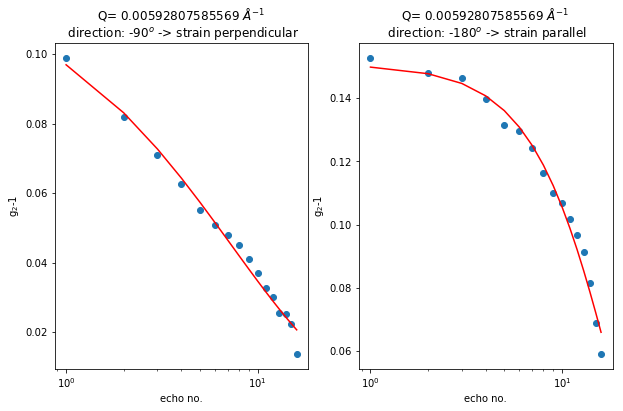

In [18]:
# single Q: speckle echo fit
Q_nr=Q_nr    # Q_nr=Q_nr or specify a different Q here
Q_nr=2
#phi=[90,-180]   #can re-define phi, if necessary


from scipy.optimize import curve_fit
def echo_fit_func(x, a, b, c):
    return a *np.exp( -1*(b*x)**c) 
roi_nr=[]
for i in phi:
    #roi_nr.append(get_roi_nr(total_res[list( suid_dict.keys() )[0]]['qval_dict'],Q_nr,i,q_nr=True,phi_nr=False, silent=True)[0])
    roi_nr.append(get_roi_nr(total_res[uid]['qval_dict'],Q_nr,i,q_nr=True,phi_nr=False, silent=False)[0])
f, (ax1, ax2,ax3) = plt.subplots(1,3, sharex='col', sharey='row',figsize=(10, 6))
plt.subplot(1,2,1)
[max_ind,min_ind]=get_echos(total_res[uid]['g2b'][:,roi_nr[0]]-1)

plt.semilogx(1+np.arange(len(max_ind)),total_res[uid]['g2b'][sorted(max_ind),roi_nr[0]]-1,'o')
popt, pcov = curve_fit(echo_fit_func, 1+np.arange(len(max_ind)),   total_res[uid]['g2b'][sorted(max_ind),roi_nr[0]]-1,bounds=([.01,-1*np.inf,0.1],[1,np.inf,4]))
plt.plot(1+np.arange(len(max_ind)),echo_fit_func(1+np.arange(len(max_ind)), *popt), 'r-', label='fit')
plt.title('Q= '+str(total_res[uid]['qval_dict'][roi_nr[0]][0])+' $\AA^{-1}$ \n direction: '+str(phi[0])+'$^o$ -> strain perpendicular')
plt.xlabel('echo no.');plt.ylabel('g$_2$-1')
print('fit parameter: '+str(popt))
perr = np.sqrt(np.diag(pcov))
print('standard deviation: '+str(perr))

plt.subplot(1,2,2)
[max_ind,min_ind]=get_echos(total_res[uid]['g2b'][:,roi_nr[1]]-1)
plt.semilogx(1+np.arange(len(max_ind)),total_res[uid]['g2b'][sorted(max_ind),roi_nr[1]]-1,'o')
popt, pcov = curve_fit(echo_fit_func, 1+np.arange(len(max_ind)),   total_res[uid]['g2b'][sorted(max_ind),roi_nr[1]]-1,bounds=([.01,-1*np.inf,0.1],[1,np.inf,4]))
plt.semilogx(1+np.arange(len(max_ind)),echo_fit_func(1+np.arange(len(max_ind)), *popt), 'r-', label='fit')
plt.title('Q= '+str(total_res[uid]['qval_dict'][roi_nr[1]][0])+' $\AA^{-1}$ \n direction: '+str(phi[1])+'$^o$ -> strain parallel')
plt.xlabel('echo no.');plt.ylabel('g$_2$-1')
print('fit parameter: '+str(popt))
perr = np.sqrt(np.diag(pcov))
print('standard deviation: '+str(perr))

In [68]:
# batch fitting all Qs:
#phi=[-90,-180]   #can re-define phi, if necessary
#1st phi: fit boundaries
a_phi1=[.01,.25];Gam_phi1=[-1*np.inf,np.inf];gam_phi1=[.1,2]
#2nd phi: fit boundaries
a_phi2=[.01,.25];Gam_phi2=[-1*np.inf,np.inf];gam_phi2=[.1,2]


#########################################
bounds_phi1=[[a_phi1[0],Gam_phi1[0],gam_phi1[0]],[a_phi1[1],Gam_phi1[1],gam_phi1[1]]]
bounds_phi2=[[a_phi2[0],Gam_phi2[0],gam_phi2[0]],[a_phi2[1],Gam_phi2[1],gam_phi2[1]]]

Q=get_roi_nr(total_res[uid]['qval_dict'],1,phi[0],q_nr=True,phi_nr=False, silent=True)[3]
phi1_a=[];phi1_Gam=[];phi1_gam=[];phi1_a_err=[];phi1_Gam_err=[];phi1_gam_err=[]
phi2_a=[];phi2_Gam=[];phi2_gam=[];phi2_a_err=[];phi2_Gam_err=[];phi2_gam_err=[]
Q1=[];Q2=[];phi1=[];phi2=[]
q_phi_dict=[]
echo_min=[];echo_max=[];t_echo_min=[];t_echo_max=[]
for l in Q:
    roi_nr=[]
    for i in phi:
        #roi_nr.append(get_roi_nr(total_res[list( suid_dict.keys() )[0]]['qval_dict'],Q_nr,i,q_nr=True,phi_nr=False, silent=True)[0])
        print('from this cell: Q: '+str(l))
        print('from this cell: phi: '+str(i))
        try:   # need to deal with ROIs that are empty, due to mask, module gaps,....
            roi_nr.append(get_roi_nr(total_res[uid]['qval_dict'],l,i,q_nr=False,phi_nr=False, silent=True)[0])
        except: 
            roi_nr.append(np.NaN)
            print('from this cell: sorry, no ROI for Q: '+str(l)+' phi: '+str(i))
    print('from this cell: Roi number list' +str(roi_nr))
    # first phi:
    if np.isnan(roi_nr[0]):
        phi1_a.append(np.NaN);phi1_Gam.append(np.NaN);phi1_gam.append(np.NaN)
        phi1_a_err.append(np.NaN);phi1_Gam_err.append(np.NaN);phi1_gam_err.append(np.NaN)
        Q1.append(l);phi1.append(phi[0])
        q_phi_dict.append([l,phi[0]])
        echo_min.append(np.array([np.NaN]));echo_max.append(np.array([np.NaN]));t_echo_min.append(np.array([np.NaN]));
        t_echo_max.append(np.array([np.NaN]))
    else:      
        Q1.append(l);phi1.append(phi[0])
        q_phi_dict.append([l,phi[0]])
        [max_ind,min_ind]=get_echos(total_res[uid]['g2b'][:,roi_nr[0]]-1)
        echo_max.append(total_res[uid]['g2b'][max_ind,roi_nr[0]]-1) 
        echo_min.append(total_res[uid]['g2b'][min_ind,roi_nr[0]]-1)  ## add more here!
        t_echo_max.append(total_res[uid]['tausb'][max_ind])
        t_echo_min.append(total_res[uid]['tausb'][min_ind])
        popt, pcov = curve_fit(echo_fit_func, 1+np.arange(len(max_ind)),   
                               total_res[uid]['g2b'][sorted(max_ind),roi_nr[0]]-1,bounds=(bounds_phi1[0],bounds_phi1[1]))
        perr = np.sqrt(np.diag(pcov))
        phi1_a.append(popt[0]);phi1_Gam.append(popt[1]);phi1_gam.append(popt[2])
        phi1_a_err.append(perr[0]);phi1_Gam_err.append(perr[1]);phi1_gam_err.append(perr[2])
    # second phi:
    if np.isnan(roi_nr[1]):
        phi2_a.append(np.NaN);phi2_Gam.append(np.NaN);phi2_gam.append(np.NaN)
        phi2_a_err.append(np.NaN);phi2_Gam_err.append(np.NaN);phi2_gam_err.append(np.NaN)
        Q2.append(l);phi2.append(phi[1])
        q_phi_dict.append([l,phi[0]])
        echo_min.append(np.array([np.NaN]));echo_max.append(np.array([np.NaN]));t_echo_min.append(np.array([np.NaN]));
        t_echo_max.append(np.array([np.NaN]))
    else:
        Q2.append(l);phi2.append(phi[1])
        [max_ind,min_ind]=get_echos(total_res[uid]['g2b'][:,roi_nr[1]]-1)
        echo_max.append(total_res[uid]['g2b'][max_ind,roi_nr[1]]-1) 
        echo_min.append(total_res[uid]['g2b'][min_ind,roi_nr[1]]-1)  ## add more here!
        t_echo_max.append(total_res[uid]['tausb'][max_ind])
        t_echo_min.append(total_res[uid]['tausb'][min_ind])
        popt, pcov = curve_fit(echo_fit_func, 1+np.arange(len(max_ind)),   
                               total_res[uid]['g2b'][sorted(max_ind),roi_nr[1]]-1,bounds=(bounds_phi2[0],bounds_phi2[1]))
        perr = np.sqrt(np.diag(pcov))
        phi2_a.append(popt[0]);phi2_Gam.append(popt[1]);phi2_gam.append(popt[2])
        phi2_a_err.append(perr[0]);phi2_Gam_err.append(perr[1]);phi2_gam_err.append(perr[2])

        
fit_Q= Q1+Q2;fit_phi=phi1+phi2;fit_a=phi1_a+phi2_a;fit_Gam=phi1_Gam+phi2_Gam;fit_gam=phi1_gam+phi2_gam
fit_a_err=phi1_a_err+phi2_a_err;fit_Gam_err=phi1_Gam_err+phi2_Gam_err;fit_gam_err=phi1_gam_err+phi2_gam_err

# create data objects that match HDF5 format
if save_data:    
    echo_min=pad_length(arr=echo_min)
    echo_max=pad_length(arr=echo_max)
    t_echo_max=pad_length(arr=t_echo_max)
    t_echo_min=pad_length(arr=t_echo_min)
    fit_Q= Q1+Q2;fit_phi=phi1+phi2;fit_a=phi1_a+phi2_a;fit_Gam=phi1_Gam+phi2_Gam;fit_gam=phi1_gam+phi2_gam
    fit_a_err=phi1_a_err+phi2_a_err;fit_Gam_err=phi1_Gam_err+phi2_Gam_err;fit_gam_err=phi1_gam_err+phi2_gam_err

from this cell: Q: 0.00222872340426
from this cell: phi: -90
from this cell: Q: 0.00222872340426
from this cell: phi: -180
from this cell: sorry, no ROI for Q: 0.00222872340426 phi: -180
from this cell: Roi number list[0, nan]
from this cell: Q: 0.00407839962997
from this cell: phi: -90
from this cell: Q: 0.00407839962997
from this cell: phi: -180
from this cell: Roi number list[3, 2]
from this cell: Q: 0.00592807585569
from this cell: phi: -90
from this cell: Q: 0.00592807585569
from this cell: phi: -180
from this cell: Roi number list[7, 6]
from this cell: Q: 0.00777775208141
from this cell: phi: -90
from this cell: Q: 0.00777775208141
from this cell: phi: -180
from this cell: Roi number list[10, 9]
from this cell: Q: 0.00962742830712
from this cell: phi: -90
from this cell: Q: 0.00962742830712
from this cell: phi: -180
from this cell: Roi number list[14, 13]
from this cell: Q: 0.0114771045328
from this cell: phi: -90
from this cell: Q: 0.0114771045328
from this cell: phi: -180
from 

/opt/conda_envs/analysis/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


from this cell: phi: -180
from this cell: Roi number list[22, 21]
from this cell: Q: 0.0151764569843
from this cell: phi: -90
from this cell: Q: 0.0151764569843
from this cell: phi: -180
from this cell: Roi number list[26, 25]
from this cell: Q: 0.01702613321
from this cell: phi: -90
from this cell: Q: 0.01702613321
from this cell: phi: -180
from this cell: Roi number list[30, 29]
from this cell: Q: 0.0188758094357
from this cell: phi: -90
from this cell: Q: 0.0188758094357
from this cell: phi: -180
from this cell: Roi number list[34, 33]
from this cell: Q: 0.0207254856614
from this cell: phi: -90
from this cell: Q: 0.0207254856614
from this cell: phi: -180
from this cell: Roi number list[38, 37]
from this cell: Q: 0.0225751618871
from this cell: phi: -90
from this cell: Q: 0.0225751618871
from this cell: phi: -180
from this cell: Roi number list[42, 41]
from this cell: Q: 0.0244248381129
from this cell: phi: -90
from this cell: Q: 0.0244248381129
from this cell: phi: -180
from this ce

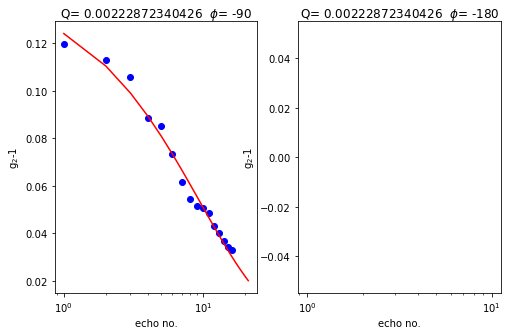

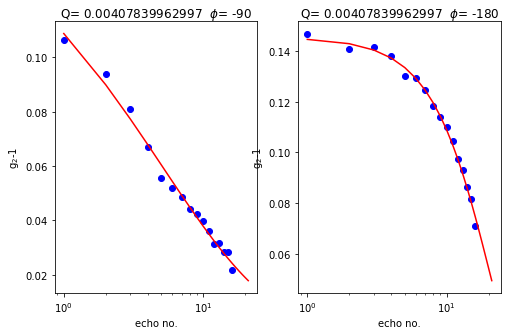

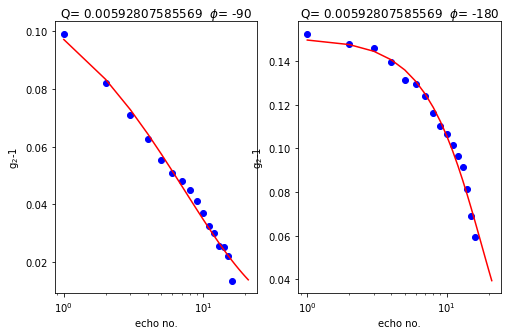

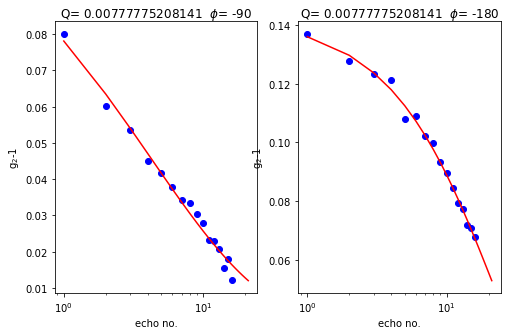

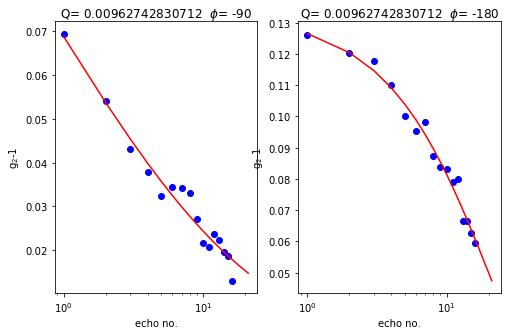

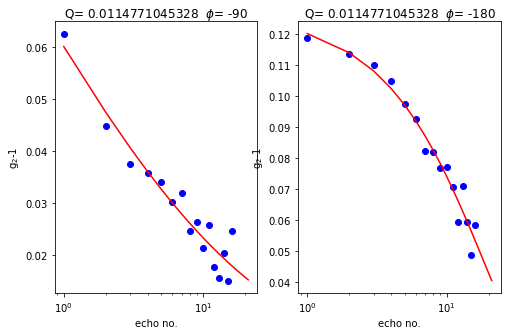

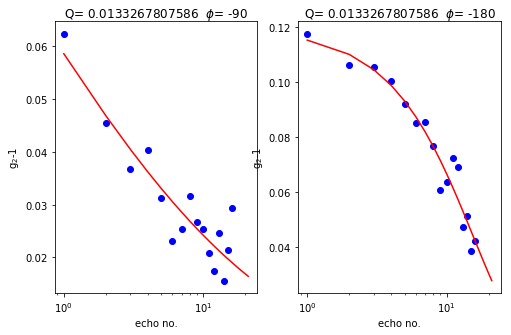

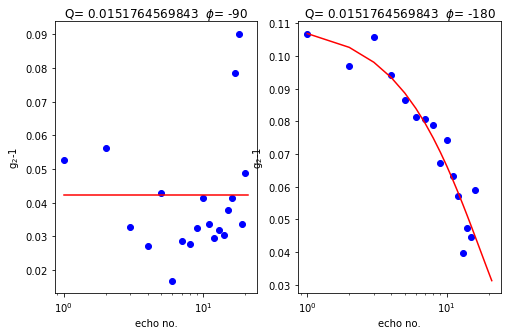

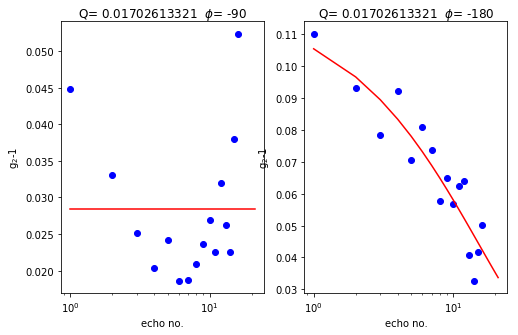

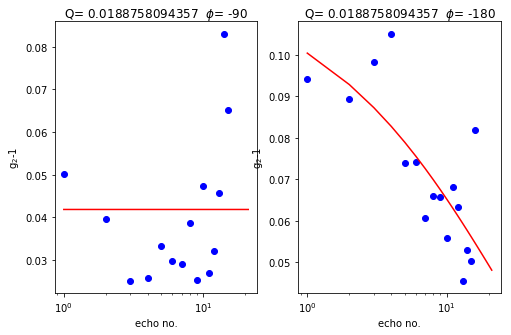

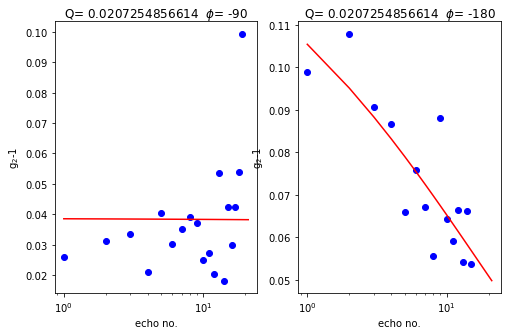

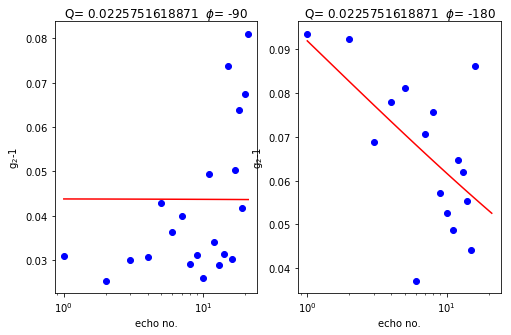

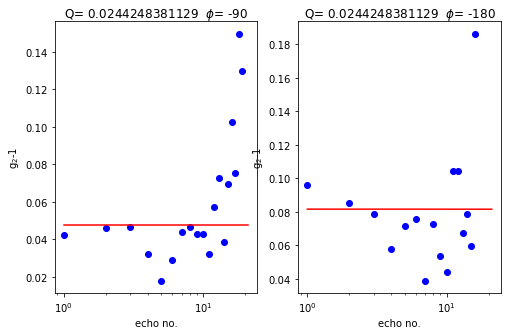

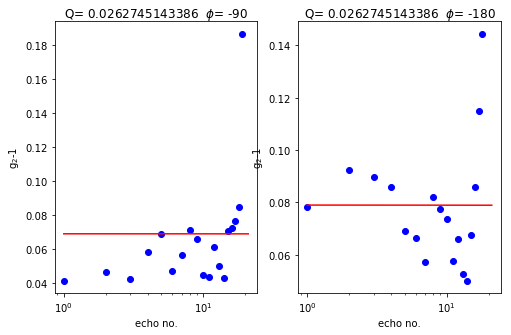

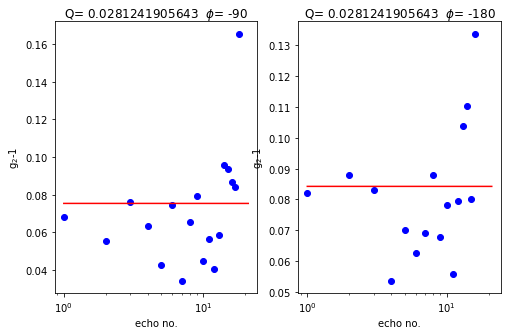

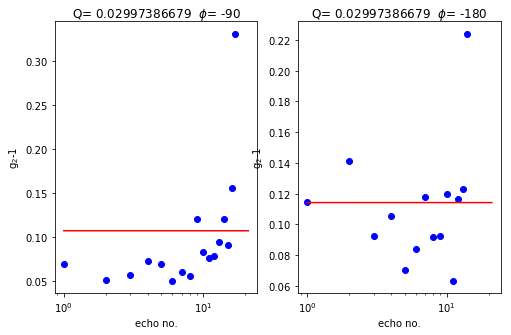

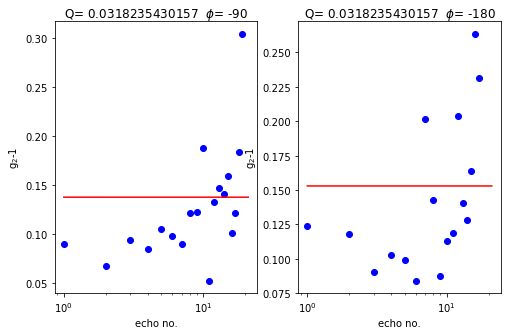

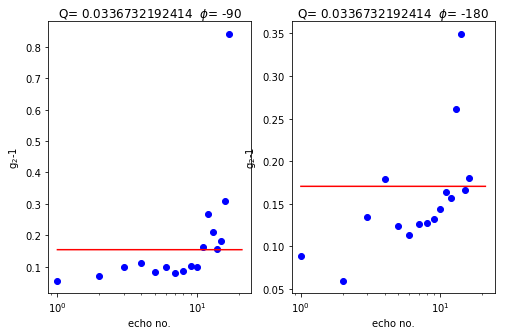

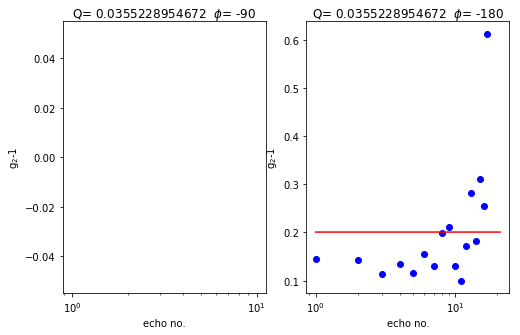

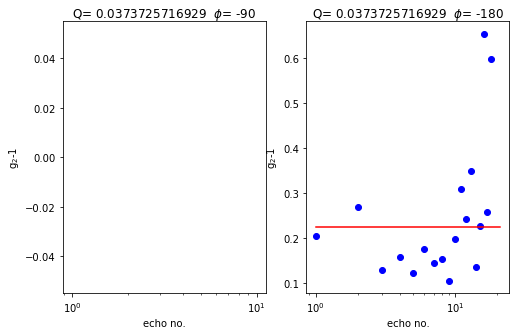

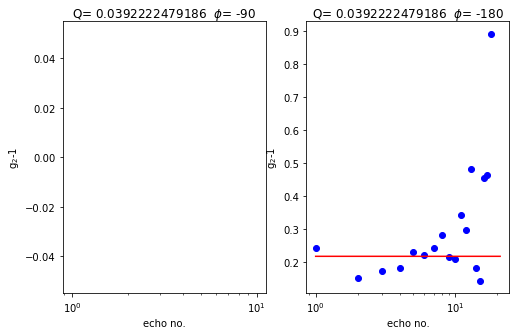

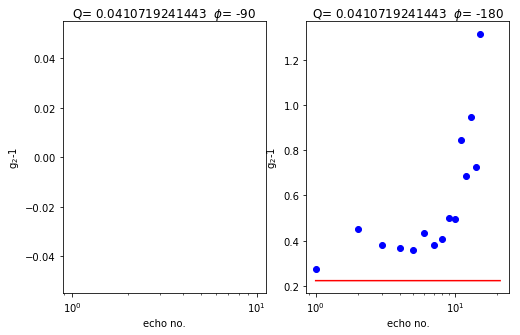

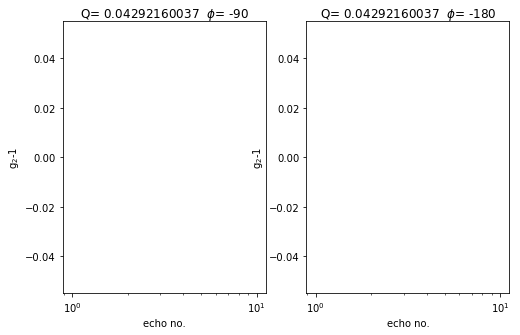

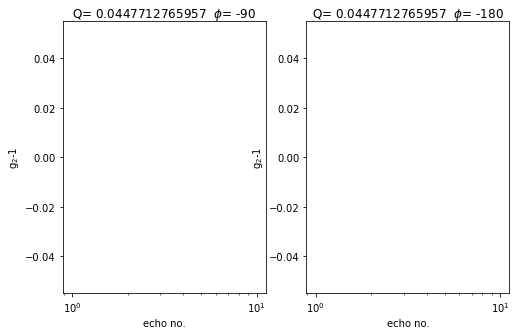

In [69]:
# TO-DO: plot all the fits with data
%matplotlib inline
for i in range(len(Q1)):
    f, (ax1, ax2,ax3) = plt.subplots(1,3, sharex='col', sharey='row',figsize=(8, 5))
    plt.subplot(1,2,1)
    plt.semilogx(1+np.arange(len(echo_max[2*i])),(echo_max[2*i]),'bo')  #fu#$%^&ing python cannot keep the order of a list...
    plt.plot(1+np.arange(len(echo_max[i])),echo_fit_func(1+np.arange(len(echo_max[i])),phi1_a[i], phi1_Gam[i], phi1_gam[i]),'r-')
    plt.xlabel('echo no.');plt.ylabel('g$_2$-1')
    plt.title('Q= '+str(Q1[i])+'  $\phi$= '+str(phi[0]))
    
    plt.subplot(1,2,2)
    plt.semilogx(1+np.arange(len(echo_max[2*i+1])),(echo_max[2*i+1]),'bo')  #fu#$%^&ing python cannot keep the order of a list...
    plt.plot(1+np.arange(len(echo_max[2*i+1])),echo_fit_func(1+np.arange(len(echo_max[2*i+1])),phi2_a[+i], phi2_Gam[i], phi2_gam[i]),'r-')
    plt.xlabel('echo no.');plt.ylabel('g$_2$-1')
    plt.title('Q= '+str(Q1[i])+'  $\phi$= '+str(phi[1]))

(-1, 1)

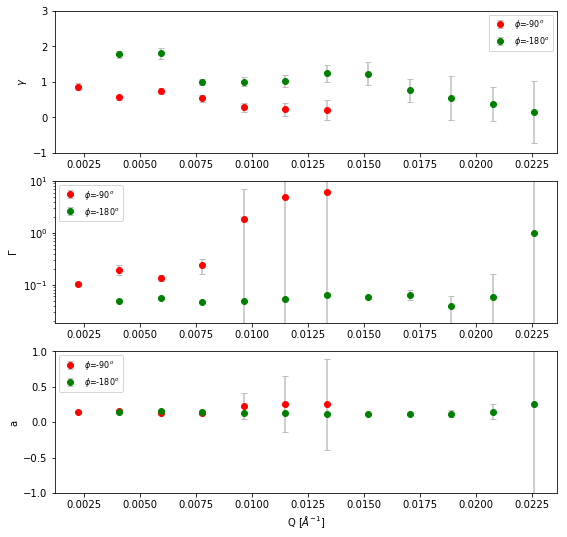

In [75]:
# plot fitting parameters:
#fig,ax=plt.subplots()
phi1_sets=[0,7]   #phi1_sets=[0,len(Q1)]
phi2_sets=[0,12] #phi2_sets=[0,len(Q2)]

###########################################
#f, (ax1, ax2,ax3) = plt.subplots(1,3, sharex='col', sharey='row',figsize=(9, 12))
from matplotlib import pyplot
f,ax1=plt.subplots(figsize=(9,12))
plt.subplot(4,1,1)
plt.errorbar(Q1[phi1_sets[0]:phi1_sets[1]], phi1_gam[phi1_sets[0]:phi1_sets[1]], yerr=phi1_gam_err[phi1_sets[0]:phi1_sets[1]], xerr=None, fmt='ro',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='$\phi$='+str(phi[0])+'$^o$')
plt.errorbar(Q2[phi2_sets[0]:phi2_sets[1]], phi2_gam[phi2_sets[0]:phi2_sets[1]], yerr=phi2_gam_err[phi2_sets[0]:phi2_sets[1]], xerr=None, fmt='go',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='$\phi$='+str(phi[1])+'$^o$')
plt.ylabel('$\gamma$') #plt.xlabel('Q [$\AA^{-1}$]')
plt.legend(fontsize=8)
plt.ylim(-1,3)

plt.subplot(4,1,2)
plt.errorbar(Q1[phi1_sets[0]:phi1_sets[1]], phi1_Gam[phi1_sets[0]:phi1_sets[1]], yerr=phi1_Gam_err[phi1_sets[0]:phi1_sets[1]], xerr=None, fmt='ro',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='$\phi$='+str(phi[0])+'$^o$')
plt.errorbar(Q2[phi2_sets[0]:phi2_sets[1]], phi2_Gam[phi2_sets[0]:phi2_sets[1]], yerr=phi2_Gam_err[phi2_sets[0]:phi2_sets[1]], xerr=None, fmt='go',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='$\phi$='+str(phi[1])+'$^o$')
plt.ylabel('$\Gamma$')#plt.xlabel('Q [$\AA^{-1}$]')
plt.legend(fontsize=8)
pyplot.yscale('log')#pyplot.xscale('log')
plt.ylim(-1,10)


plt.subplot(4,1,3)
plt.errorbar(Q1[phi1_sets[0]:phi1_sets[1]], phi1_a[phi1_sets[0]:phi1_sets[1]], yerr=phi1_a_err[phi1_sets[0]:phi1_sets[1]], xerr=None, fmt='ro',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='$\phi$='+str(phi[0])+'$^o$')
plt.errorbar(Q2[phi2_sets[0]:phi2_sets[1]], phi2_a[phi2_sets[0]:phi2_sets[1]], yerr=phi2_a_err[phi2_sets[0]:phi2_sets[1]], xerr=None, fmt='go',color = '0.75', ecolor='0.75', elinewidth=None,
             capsize=3, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1,capthick=None,
             label='$\phi$='+str(phi[1])+'$^o$')
plt.ylabel('a');plt.xlabel('Q [$\AA^{-1}$]')
plt.legend(fontsize=8)
plt.ylim(-1,1)

In [76]:
if save_data:
    md=dict()
    md['uid']= get_meta_data( uid )['uid']

    Exdt = {} 
    for k,v in zip( ['md', 'q_phi_dict','echo_max', 'echo_min','t_echo_max','t_echo_min','fit_Q','fit_phi','fit_a','fit_Gam','fit_gam',
                    'fit_a_err','fit_Gam_err','fit_gam_err'],  
                   [md,       q_phi_dict, echo_max, echo_min, t_echo_max, t_echo_min,fit_Q,fit_phi,fit_Gam,fit_gam,
                   fit_a_err,fit_Gam_err,fit_gam_err] ):
           Exdt[ k ] = v
    export_xpcs_results_to_h5( 'speckle_echo_uid_%s.h5'%md['uid'], outDir, export_dict = Exdt )
else:
    print('ATTENTION: DATA SAVING NOT ENABLED!')

The xpcs analysis results are exported to /XF11ID/analysis/2017_3/lwiegart/Results/ with filename as speckle_echo_uid_ce3b2b4a-0ad1-4ea3-82ff-54fcc109064d.h5


In [78]:
# to load data:
#extract_dict = extract_xpcs_results_from_h5( filename = 'speckle_echo_uid_%s.h5'%md['uid'], import_dir = outDir )
#extract_dict.keys()
#extract_dict['fit_gam']